# **Model Zoo -- Conditional Variational Autoencoder**

## **Libraries**

In [11]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## **Settings**

In [3]:
# Device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 10
batch_size = 128

# Architecture
num_classes = 10
num_features = 784
num_hidden_1 = 500
num_latent = 35

## **MNIST dataset**

In [4]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())

In [5]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

In [6]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## **Model**

In [7]:
def to_onehot(labels, num_classes, device):
    labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)
    return labels_onehot


class ConditionalVariationalAutoencoder(torch.nn.Module):
    def __init__(self, num_features, num_hidden_1, num_latent, num_classes):
        super(ConditionalVariationalAutoencoder, self).__init__()
        self.num_classes = num_classes
        
        self.hidden_1 = torch.nn.Linear(num_features+num_classes, num_hidden_1)
        self.z_mean = torch.nn.Linear(num_hidden_1, num_latent)
        self.z_log_var = torch.nn.Linear(num_hidden_1, num_latent)
        
        self.linear_3 = torch.nn.Linear(num_latent+num_classes, num_hidden_1)
        self.linear_4 = torch.nn.Linear(num_hidden_1, num_features+num_classes)

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features, targets):
        onehot_targets = to_onehot(targets, self.num_classes, device)
        x = torch.cat((features, onehot_targets), dim=1)

        x = self.hidden_1(x)
        x = F.leaky_relu(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded, targets):
        onehot_targets = to_onehot(targets, self.num_classes, device)
        encoded = torch.cat((encoded, onehot_targets), dim=1)        
        
        x = self.linear_3(encoded)
        x = F.leaky_relu(x)
        x = self.linear_4(x)
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features, targets):
        z_mean, z_log_var, encoded = self.encoder(features, targets)
        decoded = self.decoder(encoded, targets)
        return z_mean, z_log_var, encoded, decoded

In [8]:
torch.manual_seed(random_seed)
model = ConditionalVariationalAutoencoder(num_features, num_hidden_1, num_latent, num_classes)
model = model.to(device)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## **Training**

In [10]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        z_mean, z_log_var, encoded, decoded = model(features, targets)

        kl_divergence = (0.5 * (z_mean**2 + torch.exp(z_log_var) - z_log_var - 1)).sum()
        
        x_con = torch.cat((features, to_onehot(targets, num_classes, device)), dim=1)
        
        pixelwise_bce = F.binary_cross_entropy(decoded, x_con, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        optimizer.zero_grad()
        cost.backward()
        
        optimizer.step()
        
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader)//batch_size, cost))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/003 | Cost: 71058.9922
Epoch: 001/010 | Batch 050/003 | Cost: 26990.0059
Epoch: 001/010 | Batch 100/003 | Cost: 22627.7793
Epoch: 001/010 | Batch 150/003 | Cost: 19888.5684
Epoch: 001/010 | Batch 200/003 | Cost: 19581.2188
Epoch: 001/010 | Batch 250/003 | Cost: 19021.4512
Epoch: 001/010 | Batch 300/003 | Cost: 18069.1895
Epoch: 001/010 | Batch 350/003 | Cost: 17608.5098
Epoch: 001/010 | Batch 400/003 | Cost: 16077.9365
Epoch: 001/010 | Batch 450/003 | Cost: 16784.4629
Time elapsed: 0.49 min
Epoch: 002/010 | Batch 000/003 | Cost: 16908.3633
Epoch: 002/010 | Batch 050/003 | Cost: 15913.8848
Epoch: 002/010 | Batch 100/003 | Cost: 15675.7500
Epoch: 002/010 | Batch 150/003 | Cost: 15463.9287
Epoch: 002/010 | Batch 200/003 | Cost: 15720.4902
Epoch: 002/010 | Batch 250/003 | Cost: 15494.5547
Epoch: 002/010 | Batch 300/003 | Cost: 15036.1562
Epoch: 002/010 | Batch 350/003 | Cost: 14902.1504
Epoch: 002/010 | Batch 400/003 | Cost: 14913.0400
Epoch: 002/010 | Batch 450/

## **Evaluation**

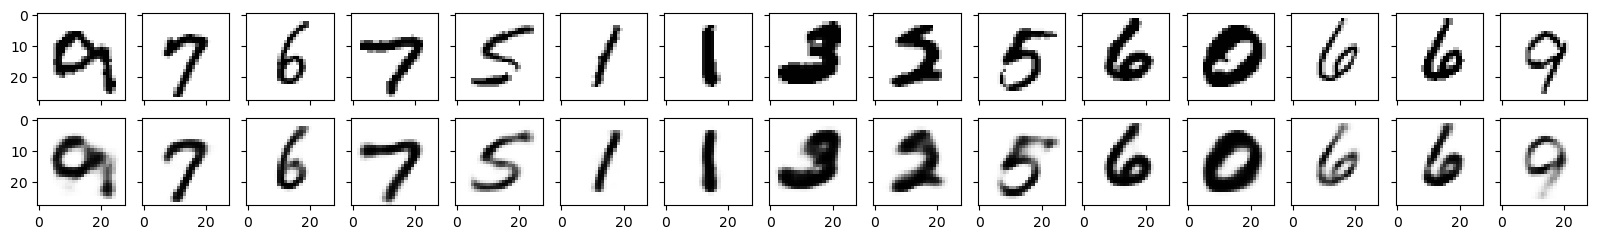

In [12]:
n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images][:, :-num_classes]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

Class Label 0


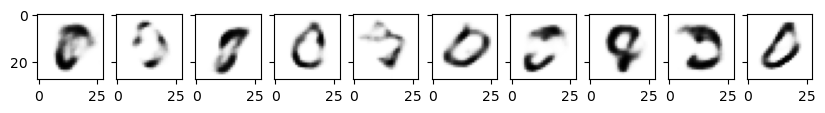

Class Label 1


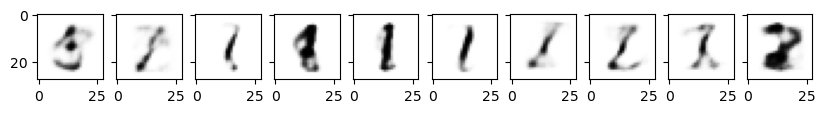

Class Label 2


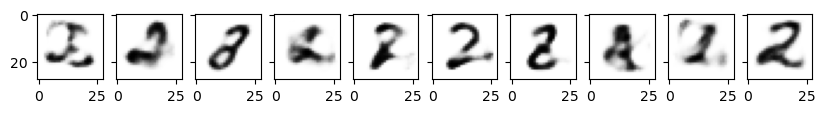

Class Label 3


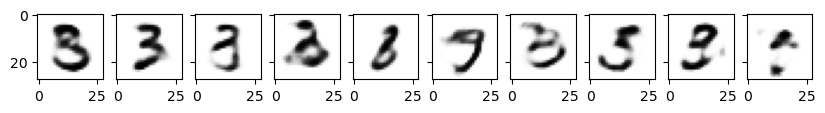

Class Label 4


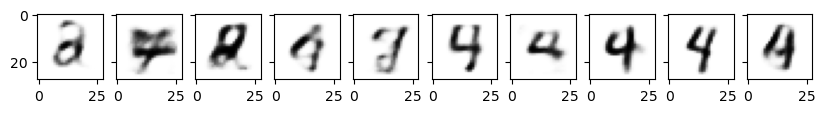

Class Label 5


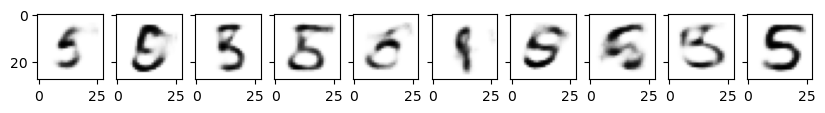

Class Label 6


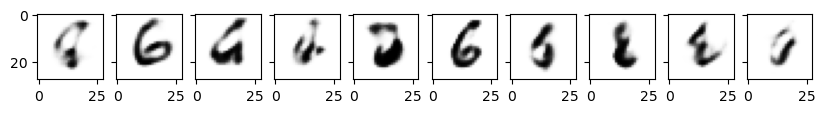

Class Label 7


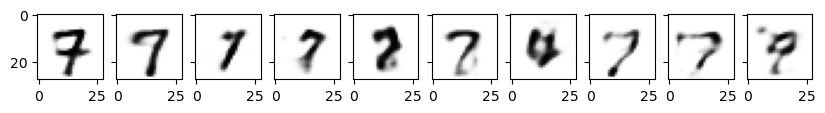

Class Label 8


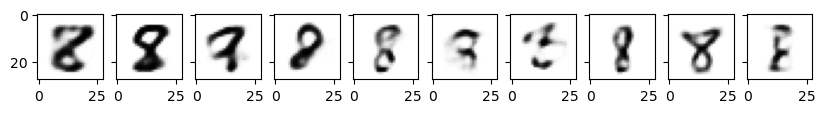

Class Label 9


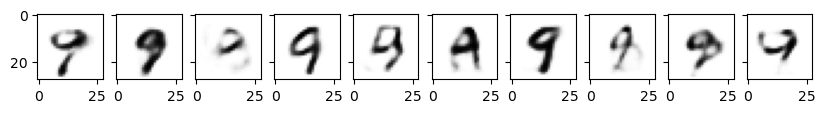

In [13]:
for i in range(10):
    labels = torch.tensor([i]*10).to(device)
    n_images = labels.size()[0]
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features, labels)

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images][:, :-num_classes]

    print('Class Label %d' % i)

    for ax, img in zip(axes, decoded_images):
        curr_img = img.detach().to(torch.device('cpu'))
        ax.imshow(curr_img.view((image_width, image_width)), cmap='binary')
        
    plt.show()